In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import keras
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, Input, Lambda
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import l2
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_dir = pathlib.Path('/content/drive/MyDrive/Skin-cancer-data/Train/')
validation_data_dir = pathlib.Path('/content/drive/MyDrive/Skin-cancer-data/Validation/')
test_data_dir = pathlib.Path('/content/drive/MyDrive/Skin-cancer-data/Test/')


In [ ]:
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(validation_data_dir.glob('*/*.jpg')))
print(image_count_test)

1954
285


In [ ]:
batch_size = 32
img_height =224 
img_width =224 

In [ ]:
train_ds =  tf.keras.utils.image_dataset_from_directory(train_data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 1954 files belonging to 9 classes.
Using 1564 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(train_data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 1954 files belonging to 9 classes.
Using 390 files for validation.


In [ ]:
class_names = train_ds.class_names
print(type(class_names), class_names)

<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


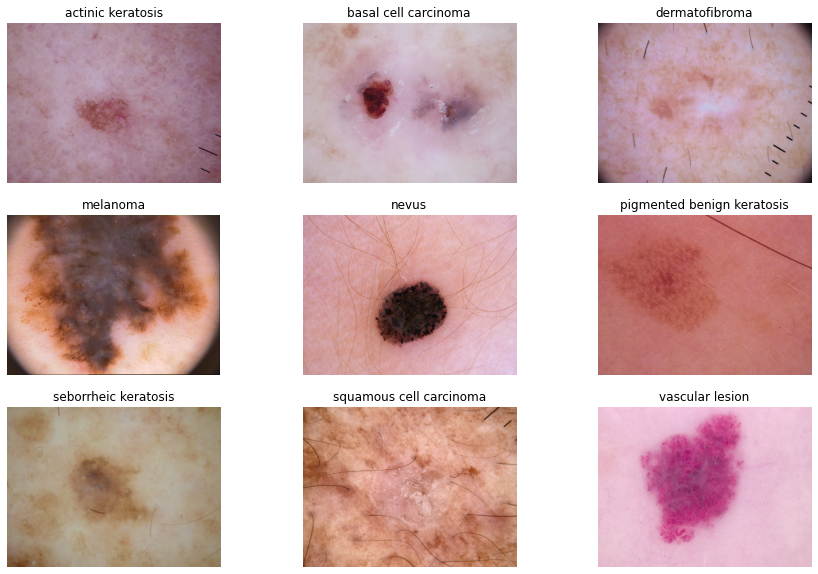

In [ ]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(train_data_dir), class_)
    file_path = glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


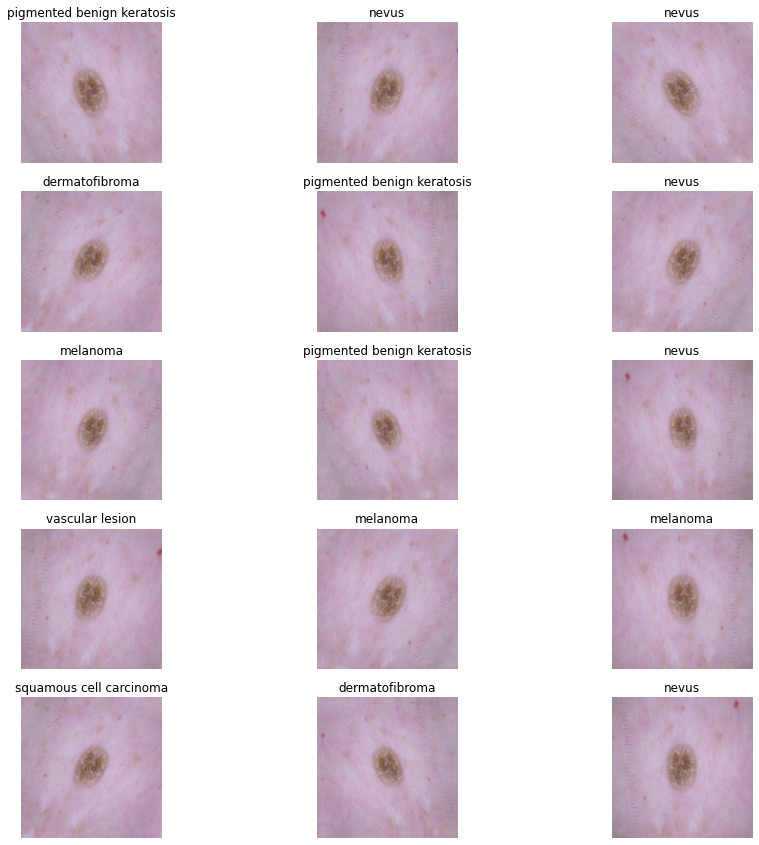

In [ ]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [ ]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(train_data_dir.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 79,
 'basal cell carcinoma': 346,
 'dermatofibroma': 95,
 'melanoma': 403,
 'nevus': 322,
 'pigmented benign keratosis': 427,
 'seborrheic keratosis': 32,
 'squamous cell carcinoma': 151,
 'vascular lesion': 99}

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,79
basal cell carcinoma,346
dermatofibroma,95
melanoma,403
nevus,322
pigmented benign keratosis,427
seborrheic keratosis,32
squamous cell carcinoma,151
vascular lesion,99


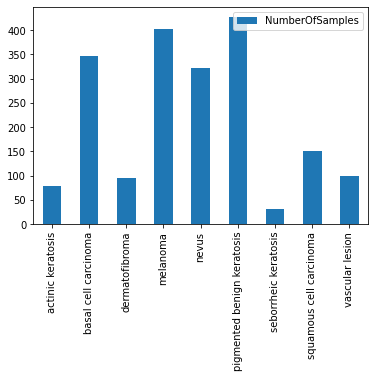

In [ ]:
class_df.plot.bar()
plt.show()

In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
path_to_training_dataset = '/content/drive/MyDrive/Skin-cancer-data/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/content/drive/MyDrive/Skin-cancer-data/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 79 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/actinic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F05C67B2810>: 100%|██████████| 1000/1000 [00:42<00:00, 23.38 Samples/s]


Initialised with 346 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05C6768790>: 100%|██████████| 1000/1000 [00:44<00:00, 22.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F05C6BB7D90>: 100%|██████████| 1000/1000 [00:43<00:00, 22.90 Samples/s]


Initialised with 403 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05C68E1090>: 100%|██████████| 1000/1000 [03:10<00:00,  5.25 Samples/s]


Initialised with 322 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F06420D8050>: 100%|██████████| 1000/1000 [03:21<00:00,  4.97 Samples/s]


Initialised with 427 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05C7B763D0>: 100%|██████████| 1000/1000 [00:42<00:00, 23.30 Samples/s]


Initialised with 32 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05C7DC9990>: 100%|██████████| 1000/1000 [01:35<00:00, 10.52 Samples/s]


Initialised with 151 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F06421AAE50>: 100%|██████████| 1000/1000 [00:42<00:00, 23.57 Samples/s]


Initialised with 99 image(s) found.
Output directory set to /content/drive/MyDrive/Skin-cancer-data/working/vascular lesion/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F05C7C10B50>: 100%|██████████| 1000/1000 [00:47<00:00, 21.10 Samples/s]


In [ ]:
output_dir = pathlib.Path('/content/drive/MyDrive/Skin-cancer-data/working/')

In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model2 = Sequential()
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model2.add(Conv2D(16, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.25))

model2.add(Conv2D(32, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.25))

model2.add(Conv2D(64, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))


In [ ]:
model2.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                        

In [ ]:
epochs = 30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


In [ ]:
model2.save('saved_models/model2.hdf5')

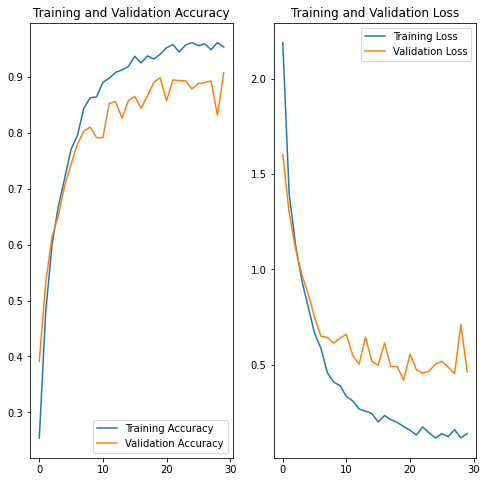

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()